In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import json
import pandas as pd
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis
import pickle
from tqdm import tqdm 
from ast import literal_eval
import cobra
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

from matplotlib.ticker import ScalarFormatter
import gurobipy
gurobipy.setParam('OutputFlag', 0)
import sys
# sys.path.append('../Script/')
sys.path.append('../retrosynthesis/')

from common import *

### input and output

In [2]:
###input
yeast870_path =  '../../Data/model/yeast-GEM.yml'
yeast8U_del_path = '../../Data/model/Yeast-MetaTwin.yml'
growth_data_path = '../../Data/growth_rate_C_N.tsv'

###output
figs5_a_path = '../../Results/Figures/figs6_a.pdf'


In [3]:
yeast8 = cobra.io.load_yaml_model(yeast870_path)
yeast8U = cobra.io.load_yaml_model(yeast8U_del_path)

In [4]:
growth_data = pd.read_csv(growth_data_path,sep='\t')
growth_data.head(10)

,GLCxtI,O2xtI,NH3xtI,experimental growth
0,3.50,7.8,0.61,0.15
1,4.61,9.2,0.74,0.18
2,5.30,1000.0,0.85,0.20
3,5.67,8.7,0.83,0.20
4,8.00,8.8,0.96,0.25
5,9.45,9.3,1.09,0.28
6,12.68,8.2,1.33,0.34
7,1.15,2.7,1000.00,0.10
8,1.17,2.5,1000.00,0.10
9,1.69,4.0,1000.00,0.15


In [5]:
def growth_simulation(model,GLC_exchange,O2_exchange,NH3_exchange):
    with model:
        model.reactions.get_by_id('r_1714').bounds = (-GLC_exchange,1000)#C
        model.reactions.get_by_id('r_1992').bounds = (-O2_exchange,1000)#O
        model.reactions.get_by_id('r_1654').bounds = (-NH3_exchange,1000)#N
        model.solver = 'gurobi'
        model.optimize()
        return model.reactions.get_by_id('r_2111').flux

In [6]:
growth_data['yeast8'] = growth_data.apply(lambda row: growth_simulation(yeast8, row['GLCxtI'], row['O2xtI'], row['NH3xtI']), axis=1)
growth_data['yeast8U'] = growth_data.apply(lambda row: growth_simulation(yeast8U, row['GLCxtI'], row['O2xtI'], row['NH3xtI']), axis=1)

In [7]:
slope, intercept, r_value, p_value, std_err = stats.linregress(growth_data['experimental growth'], growth_data['yeast8'])
r_squared = r_value**2
print(f"R² value: {r_squared}")

R² value: 0.4976024178115941


In [8]:
slope, intercept, r_value, p_value, std_err = stats.linregress(growth_data['experimental growth'], growth_data['yeast8U'])
r_squared = r_value**2
print(f"R² value: {r_squared}")

R² value: 0.6123639706192114


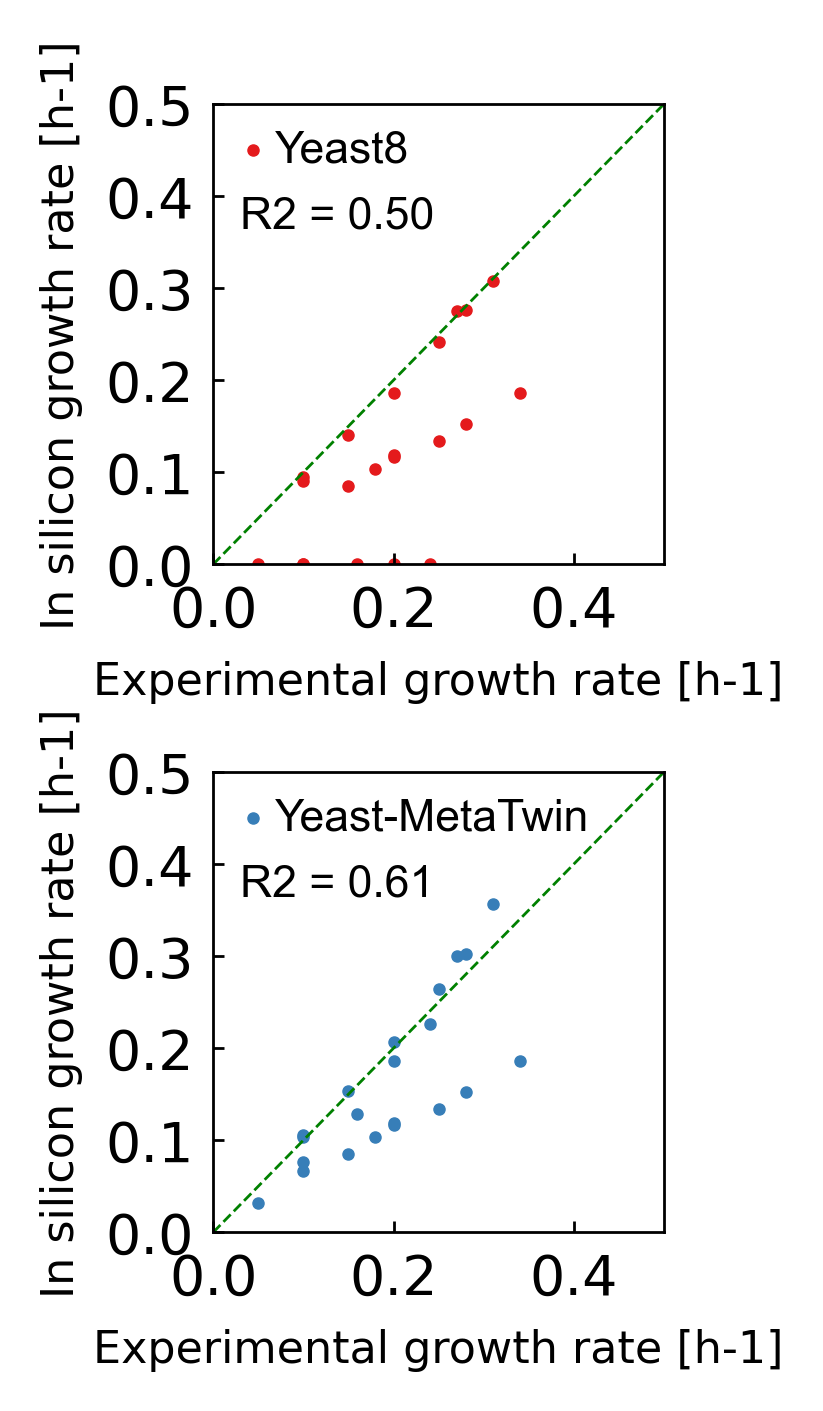

In [9]:
# Creating two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(1.8, 3.46), dpi=400)
plt.rcParams.update({'font.size': 8})
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

# Setting Axis Styles for Subplot 1
ax1.spines['top'].set_linewidth(0.5)
ax1.spines['bottom'].set_linewidth(0.5)
ax1.spines['left'].set_linewidth(0.5)
ax1.spines['right'].set_linewidth(0.5)

ax1.scatter(growth_data['experimental growth'], growth_data['yeast8'],
            s=4,  # Size of the points
            c='#e41a1c',  # Color of the points
            edgecolor='#e41a1c',  # Edge color of the points
            linewidth=0.25,  # Edge width of the points
            alpha=1,  # Opacity of the points
            label='Yeast8'  # Label
           )

ax1.plot([0, 0.5], [0, 0.5], color='green', linestyle='--', linewidth=0.5, zorder=1)

ax1.set_xlabel(r'Experimental growth rate [h-1]', fontsize=8)
ax1.set_ylabel(r'In silicon growth rate [h-1]', fontsize=8)
ax1.set_xlim(0, 0.5)
ax1.set_ylim(0, 0.5)
ax1.minorticks_off()
ax1.tick_params(axis='both', direction='in', width=0.5, which='both', length=2)

# Setting Axis Styles for Subplot 2
ax2.spines['top'].set_linewidth(0.5)
ax2.spines['bottom'].set_linewidth(0.5)
ax2.spines['left'].set_linewidth(0.5)
ax2.spines['right'].set_linewidth(0.5)

ax2.scatter(growth_data['experimental growth'], growth_data['yeast8U'],
            s=4,  # Size of the points
            c='#377eb8',  # Color of the points
            edgecolor='#377eb8',  # Edge color of the points
            linewidth=0.25,  # Edge width of the points
            alpha=1,  # Opacity of the points
            label='Yeast-MetaTwin'  # Label
           )

ax2.plot([0, 0.5], [0, 0.5], color='green', linestyle='--', linewidth=0.5, zorder=1)

ax2.set_xlabel(r'Experimental growth rate [h-1]', fontsize=8)
ax2.set_ylabel(r'In silicon growth rate [h-1]', fontsize=8)

ax2.set_xlim(0, 0.5)
ax2.set_ylim(0, 0.5)
ax2.minorticks_off()
ax2.tick_params(axis='both', direction='in', width=0.5, which='both', length=2)

# Display legends
ax1.legend(frameon=False, fontsize=8, loc='center left', bbox_to_anchor=(-0.05, 0.90), ncol=1, labelspacing=0.5, handletextpad=0, handlelength=1)
ax2.legend(frameon=False, fontsize=8, loc='center left', bbox_to_anchor=(-0.05, 0.90), ncol=1, labelspacing=0.5, handletextpad=0, handlelength=1)

ax1.text(0.03, 0.40, 'R2 = 0.50', fontsize=8, ha='left', va='top', family='Arial')
ax2.text(0.03, 0.40, 'R2 = 0.61', fontsize=8, ha='left', va='top', family='Arial')

# Display the figure
plt.tight_layout()
plt.savefig(figs5_a_path, dpi=400, bbox_inches='tight')
plt.show()

# gene ess

# biolog